<a href="https://colab.research.google.com/github/mountechsolutions/face-mask-detection/blob/master/face_mask_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d wobotintelligence/face-mask-detection-dataset
!rm kaggle.json

Saving kaggle.json to kaggle.json
100% 2.50G/2.50G [00:35<00:00, 47.6MB/s]
100% 2.50G/2.50G [00:35<00:00, 74.6MB/s]


In [ ]:
!rm -rf Medical \mask
!unzip face-mask-detection-dataset.zip

In [ ]:
!rm -rf sample_data

In [ ]:
!pip install mtcnn

# Basic Imports

In [ ]:
import os
import csv
import cv2
import json
import random
import pprint as pp
import matplotlib.pyplot as plt

# Preprocssing

In [ ]:
BASE_DIR = 'Medical mask/Medical mask/Medical Mask'
IMAGE_DIR = os.path.join(BASE_DIR, 'images')
ANNOTATIONS_DIR = os.path.join(BASE_DIR, 'annotations')

In [ ]:
for file in os.listdir(ANNOTATIONS_DIR):
  with open(os.path.join(ANNOTATIONS_DIR, file), 'r') as f:
    data = json.load(f)
    pp.pprint(data)
    break

{'Annotations': [{'Attributes': {},
                  'BoundingBox': [154, 178, 432, 544],
                  'Confidence': 1,
                  'ID': 329330485172403456,
                  'classname': 'face_with_mask',
                  'isProtected': False},
                 {'Attributes': {},
                  'BoundingBox': [171, 340, 429, 541],
                  'Confidence': 1,
                  'ID': 411605424488487232,
                  'classname': 'mask_colorful',
                  'isProtected': False}],
 'FileName': '4615.png',
 'NumOfAnno': 2}


In [ ]:
faces_with_mask = []
faces_without_mask = []

with open('train.csv', 'r') as f:
  data = list(csv.reader(f))
  
  faces_with_mask = list(filter(lambda x: x[5] == 'face_with_mask', data[1:]))
  faces_without_mask = list(filter(lambda x: x[5] == 'face_no_mask', data[1:]))

random.shuffle(faces_with_mask)
random.shuffle(faces_without_mask)

print(len(faces_with_mask), len(faces_without_mask))

4180 1569


In [ ]:
# Viewing data

fig, ax = plt.subplots(2, 5, figsize=(20, 20))

for i, face in enumerate(faces_with_mask[:5]):
  image = cv2.cvtColor(cv2.imread(os.path.join(IMAGE_DIR, face[0])), cv2.COLOR_BGR2RGB)
  start = int(face[1]), int(face[2])
  end = int(face[3]), int(face[4])
  image = image[start[1]:end[1], start[0]:end[0]]
  image = cv2.resize(image, (100, 100))
  ax[0, i].imshow(image)

for i, face in enumerate(faces_without_mask[:5]):
  image = cv2.cvtColor(cv2.imread(os.path.join(IMAGE_DIR, face[0])), cv2.COLOR_BGR2RGB)
  start = int(face[1]), int(face[2])
  end = int(face[3]), int(face[4])
  image = image[start[1]:end[1], start[0]:end[0]]
  image = cv2.resize(image, (100, 100))
  ax[1, i].imshow(image)
fig.show()

In [ ]:
X = []
y = []

for i, cat in enumerate((faces_without_mask, faces_with_mask)):
  for f in cat:
    image = cv2.cvtColor(cv2.imread(os.path.join(IMAGE_DIR, f[0])), cv2.COLOR_BGR2RGB)
    start = int(f[1]), int(f[2])
    end = int(f[3]), int(f[4])
    image = image[start[1]:end[1], start[0]:end[0]]
    image = cv2.resize(image, (100, 100))
    X.append(image)
    y.append(i)

print(len(X))
print(len(y))

5749
5749


5174 575


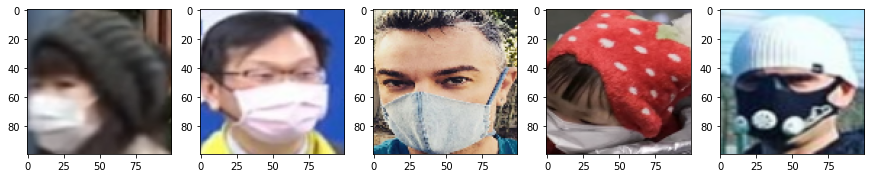

In [ ]:
# Splitting the data for training and testing
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import preprocess_input

# X_new = []

# for i, img in enumerate(X):
#   X_new.append(preprocess_input(img))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)


print(len(X_train), len(X_test))

# Viewing trainning datas
fig, ax = plt.subplots(1, 5, figsize=(15, 15))

for i, img in enumerate(X_train[:5]):
  ax[i].imshow(img)
fig.show()

X_train = np.array(X_train, dtype='float32')
y_train = np.array(y_train)
X_test = np.array(X_test, dtype='float32')
y_test = np.array(y_test)

# Creating model architecture

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.optimizers import Adam


base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(100, 100, 3)), classes=1)

new_model = base_model.output
new_model = Flatten()(new_model)
new_model = Dense(259, activation='relu')(new_model)
new_model = Dense(1, activation='sigmoid')(new_model)

for layer in base_model.layers:
  layer.trainable = False

model = Model(inputs=base_model.input, outputs=new_model)
opt = Adam(lr=1e-5)
model.compile(loss='binary_crossentropy' ,optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0  

# Training

In [ ]:
EPOCHS = 10

history = model.fit(X_train, y_train, epochs=10, validation_split=0.1)

Epoch 1/10
146/146 [==============================] - 6s 41ms/step - loss: 0.6378 - accuracy: 0.8971 - val_loss: 0.5006 - val_accuracy: 0.9286
Epoch 2/10
146/146 [==============================] - 6s 41ms/step - loss: 0.1880 - accuracy: 0.9560 - val_loss: 0.4512 - val_accuracy: 0.9286
Epoch 3/10
146/146 [==============================] - 6s 41ms/step - loss: 0.0912 - accuracy: 0.9757 - val_loss: 0.4208 - val_accuracy: 0.9305
Epoch 4/10
146/146 [==============================] - 6s 41ms/step - loss: 0.0518 - accuracy: 0.9852 - val_loss: 0.4067 - val_accuracy: 0.9344
Epoch 5/10
146/146 [==============================] - 6s 41ms/step - loss: 0.0322 - accuracy: 0.9925 - val_loss: 0.3987 - val_accuracy: 0.9305
Epoch 6/10
146/146 [==============================] - 6s 41ms/step - loss: 0.0204 - accuracy: 0.9951 - val_loss: 0.3885 - val_accuracy: 0.9363
Epoch 7/10
146/146 [==============================] - 6s 42ms/step - loss: 0.0131 - accuracy: 0.9979 - val_loss: 0.3825 - val_accuracy: 0.9421

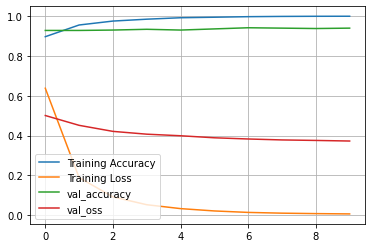

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['val_loss'], label='val_oss')
plt.grid()
plt.legend()
plt.show()

In [ ]:
eval = model.evaluate(X_test, y_test)
eval[1]

18/18 [==============================] - 1s 37ms/step - loss: 0.3096 - accuracy: 0.9339


0.9339130520820618

In [ ]:
model.save('model.h5')

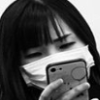

array([[1.]], dtype=float32)

In [ ]:
from google.colab.patches import cv2_imshow

image = random.choice(X_test)
cv2_imshow(image)

predictions = model.predict(image.reshape(-1, 100, 100, 3))
predictions